# IBM Data Science Capstone Project
## 'Glasgow's Music Hot Spot'

# A. Introduction

The IBM Data Science Proffesional certificate course from Coursera concludes with a final project.  Utilising the skills learnt in the data science toolset, I will apply these to a hypothetical real life problem.  The case study I have chosen is predicting which neighborhood would be best suited for a music hub in Glasgow City centre.

## A.1 The Idea

Glasgow is Scotlands largest metropolis, with nearly 600,000 residents located in its central region and up to 1.8million living in the surrounding suburbs.  It's long been considered the prominent cultural hot spot in not just Scotland, but the UK. This was supported recently with the announcement that Glasgow is the UK’s first UNESCO City of Music and UK’s top cultural and creative city (European Commission 2019).

From gigs in small venues and bars to incredible shows in arenas and city parks, Glasgow is a hotspot for live performance. Whether bagpipes or beats, traditional or techno, Glasgow is not afraid to make some noise

For this reason, Ive decided to investigate the ideal location to open a new music hub. A one stop venue where musicains come to be educated, rehearse and perfrom their own music.

## A.2 Venue Location Criteria

- It's important that this location is suitable to draw in the maximum number of people, therefore ammenities such as public transport and resturants/cafes/bars would idealy be available. 


- In addition, noise concerns have to be considered if there are to be concerts perfromed, so an optimum location would not be too close to resident homes.


- This venue will require a building with a large sqft area.  This might rule out certain central locations due to size constraints.


- Lastly information about rental and property price data will be important. An up and coming location, slightly outside the city centre may be more affodable and therefore more preferable.


## A.3 Tools and Libraries for Analysis

To help choose a location for the hub, I will analyse the various districs and neighborhoods with these methods:

- Beautiful Soup: Used to scrape website data for further processing


- Pandas: Create dataframes for easy interegation and manipulation of data


- Scikit-learn - KNN imputer class to fill in missing values based on nearest neighbours


- Geopy Geocoders: To convert address into latitude and longitude values


- Matplotlib: For ploting various graphs


- Folium Map: Visualize your data on a Leaflet map 


- Choropath Map: Visualize how rental prices vary across a Glasgow neighbourhoods on a thematic map using colour variations to highlight differences


- K-means Clustering: Unsupervised learning technique. Creates clusters of similar neighbourhoods from the scraped data. This information will be then highlighted and clearly displayed on the folium map. Its this technique that will allow me to make informed decicions on best location candidates that fit the criteria set above


## A.4 Data Description

The data I will use to inform my desicion includes:

- GLASGOW POSTAL CODE DATA: 
    
    Scraped from wikipedia using the beautiful soup library and subsequently cleaned up to  label the folium map with accurate district information.


- FOURSQUARE API DATA: 
    
    Provide useful location related data into district ammenities. Includes venue categories and their names together with other longitude and latitude information.


- PROPERTY RENTAL DATA: 
    
    Average rental prices of properties by square foot. Scraped from a local real estate website and processed for analysis. Average prices per district will be displayed in a choropleth map and later contributed to the neighborhood clustering.


- GEOJSON DATA:

    Used to create a choropleth map. Provides a useful visualisation of rent prices for each neighborhood. 


# B. Collecting data
## Installing Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner
from bs4 import BeautifulSoup
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
import geopandas as gpd #to create geopandas dataframes for use in choropleth map
import descartes #required additional package for geopandas

from geopy.geocoders import Nominatim #Collect longitude and latitude info

import requests # library to handle requests
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans # import k-means from clustering stage
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## B.1 Scraping wikipedia for Glasgow postcode data


In [2]:
html_data = requests.get('https://en.wikipedia.org/wiki/G_postcode_area')
soup = BeautifulSoup(html_data.text, 'html.parser')
table_html = soup.find_all('table')
body = table_html[1]


In [3]:
#Create dataframe from scraped data
postcode_data = pd.DataFrame(columns =['Postcode District', 'Post Town', 'Coverage', 'LocalAuthorityArea'])

for row in body.tbody.find_all('tr'):
    col = row.find_all('td')
    if (col!= []):
        postcode = col[0].text.strip()
        post_town = col[1].text.strip()
        coverage = col[2].text.strip()
        local_auth = col[3].text.strip()
        postcode_data = postcode_data.append({'Postcode District': postcode, 
                                              'Post Town': post_town, 
                                              'Coverage': coverage, 
                                              'LocalAuthorityArea': local_auth}, 
                                             ignore_index= True)

# Remove rows we dont need and reset index       
postcode_clean2 = postcode_data[postcode_data.LocalAuthorityArea != 'non-geographic'].copy()
postcode_clean2.reset_index(drop=True, inplace=True)
postcode_clean2

#Next we extract the coverage column from the dataframe for processing 
coverage_lst=[]
for row in range(len(postcode_clean2)):
    coverage_lst.append(postcode_clean2.loc[row, 'Coverage'])

#These rows dont need anyprocessing so will removed and then added back at end
coverage_tail = coverage_lst[28:]

#List of symbols to iterate over
symbols = ['C1', 'C2', 'C3', 'C4', 'C5', 
           'W1', 'W2', 'W3', 'W4', 'W5', 
           'NW', 'N1', 'N2', 'N3', 'E1', 
           'E2', 'E3', 'E4', 'SE', 'S1', 
           'S2','S3', 'S4', 'S5', 'S6', 
           'SW1','SW2', 'SW3']    

#Clean data function
def clean_data(lst):
    '''Cleans up unnecessary words from coverage_tail '''
    new_list = []
    for row in lst:
        for symbol in symbols:
            if f"Former {symbol} district:" in row:
                new_row = row.replace(f"Former {symbol} district: ", '')
                new_list.append(new_row)
            else:
                pass
    return new_list

#Call the clean data function on the coverage list then alocate to 'new' variable
cleaned_up = clean_data(coverage_lst)
#Add the unprocessed data onto the bottom to finalise the new coverage column
cleaned_up.extend(coverage_tail)

#Update Coverage column to cleaned_up coverage column 
postcode_clean2['Coverage'] = cleaned_up

#Dont require this column
postcode_clean2.drop(['Post Town', 'LocalAuthorityArea'], axis =1, inplace = True)
postcode_clean2.head()

Postcode District                                           Coverage
0                G1                                      Merchant City
1                G2                  Blythswood Hill, Anderston (part)
2                G3  Anderston, Finnieston, Garnethill, Park, Woodl...
3                G4  Calton (part), Cowcaddens (part), Drygate, Kel...
4                G5                                            Gorbals

## B.2 Geocoder and geographical coordinates

Acquire longitude and latitude data for each postcode area. This is a necessary step to go on and utilise the Foursuare api.

In [4]:
postal_codes = postcode_clean2['Postcode District']
postal_codes

lat_long = []
geolocator = Nominatim(user_agent='my_agent')
for pc in postal_codes:
    location = geolocator.geocode(f'Scotland, {pc}')
    lat_long.append([location.latitude, location.longitude])
    


For an unknown reason, some of the city centre postcodes did not match with their correct longtitude latitude information (showed Glasgow city to be in Edinburgh!). By extending the address to include 'Glasgow' was corrected. We then appended this correct data to the dataframe.

In [5]:
#Get correct lat long for city centre postcodes
city_centre_pc = postcode_clean2.iloc[0:5,0]
city_lat_long = []

geolocator = Nominatim(user_agent='my_agent') 
for pc in city_centre_pc:
    location = geolocator.geocode(f'Glasgow, Scotland, {pc}')
    city_lat_long.append([location.latitude, location.longitude])



In [6]:
#Swap in the correct city_lat_long data into the lat_long list
for i in range(0,5):
    lat_long[i] = city_lat_long[i]

g65 = [55.983341, -4.058508]
g23 = [55.902154, -4.288337]
lat_long[33] = g65
lat_long[13] = g23
ll = lat_long.copy()

In [7]:
#Create a lat_long dataframe and add to main df
lat_long_df = pd.DataFrame(ll, columns = ['Lat', 'Long'])
df = pd.concat([postcode_clean2, lat_long_df], axis=1)

# # Remove unnecessary postcode areas as outside glasgow city area
df.drop(labels=range(46,50), axis=0, inplace=True)
df.drop(labels=(31), axis=0, inplace=True)
df.reset_index(inplace=True, drop = True)
df.head()

Postcode District                                           Coverage  \
0                G1                                      Merchant City   
1                G2                  Blythswood Hill, Anderston (part)   
2                G3  Anderston, Finnieston, Garnethill, Park, Woodl...   
3                G4  Calton (part), Cowcaddens (part), Drygate, Kel...   
4                G5                                            Gorbals   

         Lat      Long  
0  55.859773 -4.252307  
1  55.863471 -4.258902  
2  55.867193 -4.273059  
3  55.871637 -4.253744  
4  55.843056 -4.242441

## B.3 Scrape average rental prices 

Sadly, I couldnt find a working dataset with typical commercial rental prices per postcode. 

Instead, I settled with a dataset containing the 2019 average prices for renting a 2 bedroom property.

Im hoping this would work as an effective price variable, helping paint a picture of the rental price variation in the post code districts of Glasgow.



In [8]:
#Scrape table from website
html_data = requests.get('https://www.citylets.co.uk/research/reports/property-rental-report-postcode-and-towns-2019-q1/')
soup = BeautifulSoup(html_data.text, 'html.parser')
table_html = soup.find_all('table')
body = table_html[3]


In [9]:
#Create dataframe from scraped data
rental_data = pd.DataFrame(columns =['Postcode', 'Price (£)'])

for row in body.tbody.find_all('tr'):
    col = row.find_all('td')
    if (col!= []):
        postcode = col[0].text.strip()
        price = col[2].text.strip()
        rental_data = rental_data.append({'Postcode': postcode, 'Price (£)': price}, ignore_index= True)
        
rental_data    

#Remove digits in parentheses
for row in rental_data:
    rental_data['Price (£)'] = rental_data['Price (£)'].str.replace(r"([\(\)]+\d+\))", "")
    rental_data['Price (£)'] = rental_data['Price (£)'].str.replace(r"[(£)(\,)]", "")
    
rental_data.drop([29], inplace=True)
rental_data.head()

Postcode Price (£)
0       G1     1011 
1       G2      951 
2       G3      880 
3       G4      824 
4       G5      720

In [220]:
# Merge the two dataframes based on Postcode index.
result = pd.merge(left=df, right=rental_data, how='left', left_on ='Postcode District', right_on='Postcode')
result['Price (£)'] = result['Price (£)'].astype(float)
final = result.drop(["Postcode"], axis=1)
final.head(10)

Postcode District                                           Coverage  \
0                G1                                      Merchant City   
1                G2                  Blythswood Hill, Anderston (part)   
2                G3  Anderston, Finnieston, Garnethill, Park, Woodl...   
3                G4  Calton (part), Cowcaddens (part), Drygate, Kel...   
4                G5                                            Gorbals   
5               G11                    Broomhill, Partick, Partickhill   
6               G12  West End (part), Cleveden, Dowanhill, Hillhead...   
7               G13                     Anniesland, Knightswood, Yoker   
8               G14                               Whiteinch, Scotstoun   
9               G15                                         Drumchapel   

         Lat      Long  Price (£)  
0  55.859773 -4.252307     1011.0  
1  55.863471 -4.258902      951.0  
2  55.867193 -4.273059      880.0  
3  55.871637 -4.253744      824.0  
4  55.843056 -4.242441      720.0  
5  55.871535 -4.302969      874.0  
6  55.883231 -4.294669      961.0  
7  55.883533 -4.327100      665.0  
8  55.880055 -4.352957      590.0  
9  55.911237 -4.360579        NaN

## B.4 Impute missing price values using KNN

KNN is an algorithm that is useful for matching a point with its closest k neighbors in a multi-dimensional space.

It can be used for data that are continuous, discrete, ordinal and categorical which makes it particularly useful for dealing with all kind of missing data.

Since there was a large number of missing values, i decided not to simply remove all the districts without data. Out of the various imputing techniques, the KNN imputer seemed to be the best way to provide price estimates for each neighborhood based on the prices from its surrounding areas.

This leaves us with our final dataframe we can use for further analysis.

In [221]:
from sklearn.impute import KNNImputer

#One hot encode postcode catagories
one_hot = pd.get_dummies(final[['Postcode District']], prefix="", prefix_sep="")
one_hot

df_temp = final[['Lat', 'Long', 'Price (£)']].copy()
#Join with lat, long, price data
knn_df = pd.concat([one_hot, df_temp], axis=1)
knn_df

#Create imputer class and fit to data
imputer = KNNImputer(n_neighbors=4, weights ='distance', metric= 'nan_euclidean')
n = imputer.fit_transform(knn_df)
new_df = pd.DataFrame(n)
new_df

#Append to final dataframe
final["Price (£)"] = new_df.iloc[:,47].copy().astype(int)
final

final.head(10)

Postcode District                                           Coverage  \
0                G1                                      Merchant City   
1                G2                  Blythswood Hill, Anderston (part)   
2                G3  Anderston, Finnieston, Garnethill, Park, Woodl...   
3                G4  Calton (part), Cowcaddens (part), Drygate, Kel...   
4                G5                                            Gorbals   
5               G11                    Broomhill, Partick, Partickhill   
6               G12  West End (part), Cleveden, Dowanhill, Hillhead...   
7               G13                     Anniesland, Knightswood, Yoker   
8               G14                               Whiteinch, Scotstoun   
9               G15                                         Drumchapel   

         Lat      Long  Price (£)  
0  55.859773 -4.252307       1011  
1  55.863471 -4.258902        951  
2  55.867193 -4.273059        880  
3  55.871637 -4.253744        824  
4  55.843056 -4.242441        720  
5  55.871535 -4.302969        874  
6  55.883231 -4.294669        961  
7  55.883533 -4.327100        665  
8  55.880055 -4.352957        590  
9  55.911237 -4.360579        676

## B.5 Create Folium map of Glasgow Districts

In [12]:
address = 'Glasgow, Scotland'

geolocator = Nominatim(user_agent="glasgow_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Glasgow are {}, {}.'.format(latitude, longitude))


# create map of Glasgow using latitude and longitude values
map_glasgow = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, long, coverage in zip(df['Lat'], df['Long'], df['Coverage']):
    label = '{}.format(coverage)'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_glasgow)  
    
map_glasgow

The geograpical coordinates of Glasgow are 55.8609825, -4.2488787.


## B.6 Foursquare API
### Collect venue data 

In [13]:
CLIENT_ID = 'OCOCDYUJ25V5B5DUJJCBRQROYERUC1ASPSLSQGZAYDYE4L2' # Foursquare ID
CLIENT_SECRET = 'SQYE2ZURUKDXYCYST21NLL5AMV4DCGXK2M2FNVJFFGKDUCSR' # Foursquare Secret
ACCESS_TOKEN = '5YLZILZU1QSFO25QG4XYUO350BH33ZXQPJB0PD0VZUUT5MIO'
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentails:
CLIENT_ID: OCOCDYUJ25V5B5DUJJCBRQROYERUC1ASPSLSQGZAYDYE4L2
CLIENT_SECRET:SQYE2ZURUKDXYCYST21NLL5AMV4DCGXK2M2FNVJFFGKDUCSR


In [14]:
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&oauth_token={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, ACCESS_TOKEN, latitude, longitude, VERSION, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?client_id=OCOCDYUJ25V5B5DUJJCBRQROYERUC1ASPSLSQGZAYDYE4L2&client_secret=SQYE2ZURUKDXYCYST21NLL5AMV4DCGXK2M2FNVJFFGKDUCSR&oauth_token=5YLZILZU1QSFO25QG4XYUO350BH33ZXQPJB0PD0VZUUT5MIO&ll=55.8609825,-4.2488787&v=20180605&radius=500&limit=100'

In [215]:
results = requests.get(url).json()


In [16]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [17]:
venues = results['response']['groups'][0]['items']

from pandas.io.json import json_normalize
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/Users/alexbaylis/opt/anaconda3/envs/Deadlyrics37/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  after removing the cwd from sys.path.


name   categories        lat       lng
0           Paesano Pizza  Pizza Place  55.859721 -4.250754
1  DogHouse Merchant City     Beer Bar  55.859377 -4.247850
2           George Square        Plaza  55.861164 -4.250207
3      Hutchesons Glasgow   Steakhouse  55.859800 -4.247892
4           Tempo Tea Bar     Tea Room  55.859609 -4.251961

In [18]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


# C. Data Analysis
## C.1 Choropleth map of Post code price data

Here we will create a choropleth map showing the varying rental price per post code district.

I found this data freely available from the National Records of Scotland website:

https://www.nrscotland.gov.uk/statistics-and-data/geography/our-products/scottish-postcode-directory/2021-1

In [19]:
#Read shape file and convert to geojson
myshpfile = gpd.read_file('/Users/alexbaylis/Downloads/District_21_1/District_21_1.shp')
myshpfile.to_file('glasgow.geojson', driver='GeoJSON')


In [213]:
#Take only the glasgow postcode data 
glas_geo_json = myshpfile.iloc[134:183].copy()
print(f' Number of districts in original data = {len(glas_geo_json)}')

#Select postcodes found from original dataframe
temp = final[['Postcode District']].copy()
temp.columns = ['Postcode_D']

#Check what postcodes match with our orignial dataframe
glas_geo_json.District.isin(temp.Postcode_D)
rows = [165, 180, 181, 182]

#Delete the unwanted postcodes from geo data 
glas_geo_json.drop(rows, inplace = True)
print(f' Number of districts in filtered data = {len(glas_geo_json)}')



 Number of districts in original data = 49
 Number of districts in filtered data = 45


In [212]:
glas_geo_json.head()


OBJECTID District    Shape_Leng    Shape_Area  \
134       135       G1  13151.783133  1.243900e+06   
135       136      G11   9782.162108  2.417806e+06   
136       137      G12  10109.308828  3.870850e+06   
137       138      G13  12701.796871  6.666902e+06   
138       139      G14  12724.565904  3.746784e+06   

                                              geometry  
134  MULTIPOLYGON (((258309.000 664914.950, 258294....  
135  MULTIPOLYGON (((256154.494 666275.191, 256144....  
136  POLYGON ((255713.000 669064.000, 255740.000 66...  
137  POLYGON ((253436.404 670545.898, 253447.799 67...  
138  POLYGON ((251047.000 669000.000, 251099.000 66...

<AxesSubplot:>

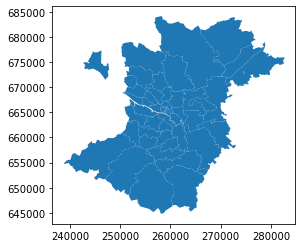

In [22]:
glas_geo_json.plot()

In [23]:
#Create world map
world_map = folium.Map(location=[55.859773, -4.252307], zoom_start = 10, tiles ='openstreetmap')

choropleth = folium.Choropleth(
    geo_data=glas_geo_json,
    data=final,
    columns=['Postcode District', 'Price (£)'],
    key_on='feature.properties.District',
    fill_color='OrRd', 
    fill_opacity=0.6, 
    line_opacity=0.4,
    legend_name='Postcode Rental Price'
).add_to(world_map)

style_function = "font-size: 15px; font-weight: bold"
choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['District'], style=style_function, labels=False))

# display map
world_map

/Users/alexbaylis/opt/anaconda3/envs/Deadlyrics37/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Now we can clearly see the most expensive neighborhoods to rent a property. These include the city centre (G1, G2) the westend (G3, G12) and some of the western suburbs (G61, G62).

## C.2 Explore Glasgow neighborhoods

In [24]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    """Fuction that gets venue location data from foursquare api. 
        Then create a dataframe with the results"""
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&oauth_token={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            ACCESS_TOKEN,
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [25]:
glasgow_venues = getNearbyVenues(names=final['Coverage'],
                                  latitudes=final['Lat'],
                                  longitudes=final['Long'],
                                  radius=1000)


Merchant City
Blythswood Hill, Anderston (part)
Anderston, Finnieston, Garnethill, Park, Woodlands (part), Yorkhill
Calton (part), Cowcaddens (part), Drygate, Kelvinbridge, Townhead, Woodlands (part), Woodside (part)
Gorbals
Broomhill, Partick, Partickhill
West End (part), Cleveden, Dowanhill, Hillhead, Hyndland, Kelvindale, Kelvinside, Botanic Gardens, University of Glasgow
Anniesland, Knightswood, Yoker
Whiteinch, Scotstoun
Drumchapel
Maryhill, North Kelvinside, Ruchill
Balornock, Barmulloch, Cowlairs, Royston, Springburn, Sighthill
Milton, Parkhouse, Possilpark
Lambhill, Summerston
Dennistoun, Haghill, Parkhead (part)
Carmyle, Tollcross, Mount Vernon, Lightburn, Sandyhills, Shettleston, Springboig
Cardowan, Carntyne, Craigend, Cranhill, Garthamlock, Millerston, Provanmill, Queenslie, Riddrie, Robroyston, Ruchazie, Stepps, Wellhouse
Easterhouse, Easthall, Provanhall
Bridgeton, Calton, Dalmarnock
Pollokshields, Shawlands
Battlefield, Govanhill, Mount Florida, Strathbungo (part), Toryg

In [211]:
print(glasgow_venues.shape)
glasgow_venues.head()

(1323, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Merchant City              55.859773               -4.252307   
1  Merchant City              55.859773               -4.252307   
2  Merchant City              55.859773               -4.252307   
3  Merchant City              55.859773               -4.252307   
4  Merchant City              55.859773               -4.252307   

               Venue  Venue Latitude  Venue Longitude Venue Category  
0      Paesano Pizza       55.859721        -4.250754    Pizza Place  
1  Max's Bar & Grill       55.859481        -4.252015            Pub  
2     The Lighthouse       55.859690        -4.255414    Event Space  
3    Miller & Carter       55.861210        -4.254378     Steakhouse  
4      Tempo Tea Bar       55.859609        -4.251961       Tea Room

## C.3 Count  and group the number of venues in each neighborhood 

In [27]:
glasgow_venues.groupby('Neighborhood').count()
 


Neighborhood Latitude  \
Neighborhood                                                                
Anderston, Finnieston, Garnethill, Park, Woodla...                    100   
Anniesland, Knightswood, Yoker                                         32   
Arden, Carnwadric, Deaconsbank, Giffnock, Kenni...                     27   
Auldhouse, East Kilbride (south)                                        6   
Baillieston, Bargeddie, Chryston, Garrowhill, G...                      5   
Baldernock, Milngavie, Mugdock                                         23   
Balornock, Barmulloch, Cowlairs, Royston, Sprin...                     11   
Barrhead, Neilston, Uplawmoor                                           8   
Battlefield, Govanhill, Mount Florida, Strathbu...                     43   
Bearsden                                                               13   
Birkenshaw, Bothwell, Broomhouse, Tannochside, ...                      9   
Bishopbriggs, Torrance                                                 14   
Blantyre, Cambuslang                                                    5   
Blythswood Hill, Anderston (part)                                     100   
Bowling, Old Kilpatrick                                                 4   
Bridgeton, Calton, Dalmarnock                                          49   
Broomhill, Partick, Partickhill                                       100   
Busby, Carmunnock, Clarkston, Eaglesham, Waterf...                     18   
Calton (part), Cowcaddens (part), Drygate, Kelv...                    100   
Cardonald, Hillington, Penilee, Mosspark                               27   
Cardowan, Carntyne, Craigend, Cranhill, Gartham...                      5   
Carmyle, Tollcross, Mount Vernon, Lightburn, Sa...                     17   
Castlemilk                                                              5   
Cathcart, Simshill, Croftfoot, King's Park, Mui...                     15   
Clachan of Campsie, Haughhead, Kirkintilloch, L...                      4   
Croy, Kilsyth, Twechar                                                  6   
Cumbernauld (north), Dullatur                                          11   
Cumbernauld (south)                                                    43   
Darnley, Pollok, Crookston, Parkhouse, Priesthi...                     40   
Dennistoun, Haghill, Parkhead (part)                                   42   
Drumchapel                                                              9   
East Kilbride (north), Thorntonhall                                     3   
Easterhouse, Easthall, Provanhall                                      26   
Gorbals                                                                14   
Govan, Ibrox, Drumoyne, Cessnock, Plantation                           27   
Lambhill, Summerston                                                    6   
Mansewood, Newlands, Pollokshaws                                       18   
Maryhill, North Kelvinside, Ruchill                                    35   
Merchant City                                                         100   
Milton, Parkhouse, Possilpark                                          18   
Newton Mearns                                                          18   
Pollokshields, Shawlands                                               14   
Rutherglen                                                              9   
West End (part), Cleveden, Dowanhill, Hillhead,...                     76   
Whiteinch, Scotstoun                                                   68   

                                                    Neighborhood Longitude  \
Neighborhood                                                                 
Anderston, Finnieston, Garnethill, Park, Woodla...                     100   
Anniesland, Knightswood, Yoker                                          32   
Arden, Carnwadric, Deaconsbank, Giffnock, Kenni...                      27   
Auldhouse, East Kilbride (south)          

In [28]:
print('There are {} uniques venue categories.'.format(len(glasgow_venues['Venue Category'].unique())))

There are 198 uniques venue categories.


## C.4 One hot encoding

One hot encoding is a technique used to encode categorical data (here the venue categories against the neighborhoods) to a binary format for use in ML modeling.

It creates a sparse data frame, taking every venue category variable and allocating it a 1 if present in that specific neighborhood and 0 if absent. 

In [210]:
# one hot encoding
glasgow_onehot = pd.get_dummies(glasgow_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
glasgow_onehot['Neighborhood'] = glasgow_venues['Neighborhood'] 

# move neighborhood column to the first column
neighborhood_col = glasgow_onehot.pop('Neighborhood')
glasgow_onehot.insert(0, 'Neighborhood', neighborhood_col)

print(glasgow_onehot.shape)
glasgow_onehot.head()


(1323, 199)


Neighborhood  Accessories Store  American Restaurant  Art Gallery  \
0  Merchant City                  0                    0            0   
1  Merchant City                  0                    0            0   
2  Merchant City                  0                    0            0   
3  Merchant City                  0                    0            0   
4  Merchant City                  0                    0            0   

   Asian Restaurant  Athletics & Sports  Auto Garage  Automotive Shop  \
0                 0                   0            0                0   
1                 0                   0            0                0   
2                 0                   0            0                0   
3                 0                   0            0                0   
4                 0                   0            0                0   

   BBQ Joint  Bagel Shop  Bakery  Bank  Bar  Bed & Breakfast  Beer Bar  \
0          0           0       0     0    0                0         0   
1          0           0       0     0    0                0         0   
2          0           0       0     0    0                0         0   
3          0           0       0     0    0                0         0   
4          0           0       0     0    0                0         0   

   Beer Store  Betting Shop  Bike Shop  Bistro  Boat or Ferry  Bookstore  \
0           0             0          0       0              0          0   
1           0             0          0       0              0          0   
2           0             0          0       0              0          0   
3           0             0          0       0              0          0   
4           0             0          0       0              0          0   

   Botanical Garden  Boutique  Bowling Green  Brazilian Restaurant  \
0                 0         0              0                     0   
1                 0         0              0                     0   
2                 0         0              0                     0   
3                 0         0              0                     0   
4                 0         0              0                     0   

   Breakfast Spot  Brewery  Bridal Shop  Burger Joint  Burrito Place  \
0               0        0            0             0              0   
1               0        0            0             0              0   
2               0        0            0             0              0   
3               0        0            0             0              0   
4               0        0            0             0              0   

   Bus Station  Bus Stop  Business Service  Café  Canal  Carpet Store  Castle  \
0            0         0                 0     0      0             0       0   
1            0         0                 0     0      0             0       0   
2            0         0                 0     0      0             0       0   
3            0         0                 0     0      0             0       0   
4            0         0                 0     0      0             0       0   

   Chinese Restaurant  Climbing Gym  Clothing Store  Cocktail Bar  \
0                   0             0               0             0   
1                   0             0               0             0   
2                   0             0               0             0   
3                   0             0               0             0   
4                   0             0               0             0   

   Coffee Shop  College Administrative Building  College Gym  Comedy Club  \
0            0                                0            0            0   
1            0                                0            0            0   
2            0                                0            0            0   
3            0                                0            0            0   
4            0                                0            0            0   

   Co

### Now, let's group the rows by neighborhood and calculate the mean frequency of occurence of each neighborhood venue category.

In [30]:
glasgow_grouped = glasgow_onehot.groupby(['Neighborhood']).mean().reset_index()
glasgow_grouped.head()

Neighborhood  Accessories Store  \
0  Anderston, Finnieston, Garnethill, Park, Woodl...                0.0   
1                     Anniesland, Knightswood, Yoker                0.0   
2  Arden, Carnwadric, Deaconsbank, Giffnock, Kenn...                0.0   
3                   Auldhouse, East Kilbride (south)                0.0   
4  Baillieston, Bargeddie, Chryston, Garrowhill, ...                0.0   

   American Restaurant  Art Gallery  Asian Restaurant  Athletics & Sports  \
0                  0.0          0.0               0.0            0.000000   
1                  0.0          0.0               0.0            0.000000   
2                  0.0          0.0               0.0            0.000000   
3                  0.0          0.0               0.0            0.166667   
4                  0.0          0.0               0.0            0.000000   

   Auto Garage  Automotive Shop  BBQ Joint  Bagel Shop  Bakery     Bank  \
0      0.00000              0.0        0.0         0.0     0.0  0.00000   
1      0.03125              0.0        0.0         0.0     0.0  0.03125   
2      0.00000              0.0        0.0         0.0     0.0  0.00000   
3      0.00000              0.0        0.0         0.0     0.0  0.00000   
4      0.00000              0.0        0.0         0.0     0.0  0.00000   

        Bar  Bed & Breakfast  Beer Bar  Beer Store  Betting Shop  Bike Shop  \
0  0.120000             0.01       0.0         0.0       0.00000        0.0   
1  0.000000             0.00       0.0         0.0       0.03125        0.0   
2  0.037037             0.00       0.0         0.0       0.00000        0.0   
3  0.166667             0.00       0.0         0.0       0.00000        0.0   
4  0.000000             0.00       0.0         0.0       0.00000        0.0   

   Bistro  Boat or Ferry  Bookstore  Botanical Garden  Boutique  \
0     0.0            0.0       0.01               0.0       0.0   
1     0.0            0.0       0.00               0.0       0.0   
2     0.0            0.0       0.00               0.0       0.0   
3     0.0            0.0       0.00               0.0       0.0   
4     0.0            0.0       0.00               0.0       0.0   

   Bowling Green  Brazilian Restaurant  Breakfast Spot  Brewery  Bridal Shop  \
0        0.00000                   0.0             0.0      0.0          0.0   
1        0.03125                   0.0             0.0      0.0          0.0   
2        0.00000                   0.0             0.0      0.0          0.0   
3        0.00000                   0.0             0.0      0.0          0.0   
4        0.00000                   0.0             0.0      0.0          0.0   

   Burger Joint  Burrito Place  Bus Station  Bus Stop  Business Service  \
0      0.000000            0.0          0.0       0.0               0.0   
1      0.000000            0.0          0.0       0.0               0.0   
2      0.037037            0.0          0.0       0.0               0.0   
3      0.000000            0.0          0.0       0.0               0.0   
4      0.000000            0.0          0.0       0.0               0.0   

       Café  Canal  Carpet Store  Castle  Chinese Restaurant  Climbing Gym  \
0  0.070000    0.0           0.0     0.0            0.030000           0.0   
1  0.093750    0.0           0.0     0.0            0.000000           0.0   
2  0.037037    0.0           0.0     0.0            0.037037           0.0   
3  0.166667    0.0           0.0     0.0            0.000000           0.0   
4  0.000000    0.0           0.0     0.0            0.200000           0.0   

   Clothing Store  Cocktail Bar  Coffee Shop  College Administrative Building  \
0            0.01          0.01         0.06                              0.0   
1            0.00          0.00         0.00                              0.0   
2            0.00          0.00         0.00                              0.0   
3            0.00          0.00         0.00                            

In [31]:
glasgow_grouped.shape

(45, 199)

## C.5  Analyse most common venues per neighborhood 

Now let's construct a dataframe containing the 10 most popular venue categories in each neighborhood.  We can use this to gain insights into the local amenities and general feel of each area.



In [32]:
#Let's print each neighborhood along with the 5 most common venues
num_top_venues = 5

for hood in glasgow_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = glasgow_grouped[glasgow_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Anderston, Finnieston, Garnethill, Park, Woodlands (part), Yorkhill----
               venue  freq
0                Bar  0.12
1         Restaurant  0.10
2  Indian Restaurant  0.07
3               Café  0.07
4              Hotel  0.06


----Anniesland, Knightswood, Yoker----
            venue  freq
0            Café  0.09
1        Platform  0.06
2  Discount Store  0.06
3             Pub  0.06
4   Train Station  0.06


----Arden, Carnwadric, Deaconsbank, Giffnock, Kennishead, Thornliebank, northeast Newton Mearns----
                venue  freq
0         Supermarket  0.15
1       Train Station  0.07
2         Pizza Place  0.07
3                Café  0.04
4  Chinese Restaurant  0.04


----Auldhouse, East Kilbride (south)----
                venue  freq
0    Department Store  0.17
1  Athletics & Sports  0.17
2         Supermarket  0.17
3                Café  0.17
4                 Bar  0.17


----Baillieston, Bargeddie, Chryston, Garrowhill, Gartcosh, Gartloch, Moodiesburn, Muirhead, S

In [33]:
# Function to sort venues in descending order:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


In [34]:
#Create dataframe and display the top 10 venues for each neighborhood
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = glasgow_grouped['Neighborhood']

for ind in np.arange(glasgow_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(glasgow_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

Neighborhood  \
0  Anderston, Finnieston, Garnethill, Park, Woodl...   
1                     Anniesland, Knightswood, Yoker   
2  Arden, Carnwadric, Deaconsbank, Giffnock, Kenn...   
3                   Auldhouse, East Kilbride (south)   
4  Baillieston, Bargeddie, Chryston, Garrowhill, ...   
5                     Baldernock, Milngavie, Mugdock   
6  Balornock, Barmulloch, Cowlairs, Royston, Spri...   
7                      Barrhead, Neilston, Uplawmoor   
8  Battlefield, Govanhill, Mount Florida, Strathb...   
9                                           Bearsden   

        1st Most Common Venue 2nd Most Common Venue    3rd Most Common Venue  \
0                         Bar            Restaurant        Indian Restaurant   
1                        Café              Platform           Discount Store   
2                 Supermarket           Pizza Place            Train Station   
3            Department Store    Athletics & Sports  Health & Beauty Service   
4  Construction & Landscaping    Chinese Restaurant            Train Station   
5                         Bar                 Hotel              Supermarket   
6               Train Station  Fast Food Restaurant           Discount Store   
7               Grocery Store  Fast Food Restaurant        Electronics Store   
8                        Café                   Pub       Italian Restaurant   
9                    Platform         Grocery Store     Fast Food Restaurant   

  4th Most Common Venue       5th Most Common Venue  
0                  Café                 Coffee Shop  
1         Train Station                         Pub  
2         Deli / Bodega                        Park  
3           Supermarket                        Café  
4             Gift Shop               Women's Store  
5                 Plaza                        Café  
6          Soccer Field                   Pawn Shop  
7           Supermarket            Business Service  
8         Grocery Store  Construction & Landscaping  
9     Food & Drink Shop                    Pharmacy

# D. K-means Clustering

## D.1 Scaling

We start by scaling the price column using standard_scaler class from scikit learn. 

Standardization is a common requirement for many machine learning estimators: they might behave badly if the individual features do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance).


In [35]:
# Its a good idea to scale the price features before using k-means clustering
from sklearn.preprocessing import StandardScaler

p = final['Price (£)'].copy()
scaler = StandardScaler()
scaler_cluster = scaler.fit_transform(p.values.reshape(-1,1))

sc_df = pd.DataFrame(scaler_cluster, columns=['Price Scaled'])

#Drop Neighborhood column
glasgow_grouped_clustering = glasgow_grouped.drop('Neighborhood', 1)
glasgow_grouped_clustering.shape

#Final processing - Append the 10 most common venues dataframe with the scaled prices column
glasgow_grouped_clustering['Price Scaled'] = sc_df



## D.2 Silhouette score

Next, to help pick the best number of clusters, we use a metric called a silhouette score.

A silhotette score varys between -1 and 1, with close to  1 indicating instances are well inside their cluster and close to 0 meaning they are on the cluster boundary.

Close to -1 means they are likely in the wrong cluster!

 
 The silhouette score for 2 is: 0.6076404431248543
 
 The silhouette score for 3 is: 0.4405248709164939
 
 The silhouette score for 4 is: 0.4197892700422071
 
 The silhouette score for 5 is: 0.36938616402641006
 
 The silhouette score for 6 is: 0.31129560129994294
 
 The silhouette score for 7 is: 0.2793603942067682
 
 The silhouette score for 8 is: 0.2336777554421722
 
 The silhouette score for 9 is: 0.20208431498684515
 
 The silhouette score for 10 is: 0.2228253542438868


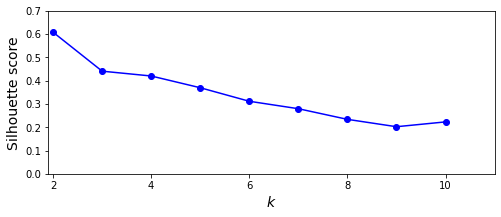

In [36]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(glasgow_grouped_clustering)
                for k in range(1, 11)]

#Import silhouette score and get scores for each number of k clusters
from sklearn.metrics import silhouette_score
silhouette_scores = [silhouette_score(glasgow_grouped_clustering, model.labels_)
                     for model in kmeans_per_k[1:]]

for k, score in enumerate(silhouette_scores):
    print(f' \n The silhouette score for {k+2} is: {score}')

#Plot the scores vs number of clusters    
plt.figure(figsize=(8, 3))
plt.plot(range(2, 11), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.9, 11, 0.0, 0.7])

plt.show()

## D.3 Silhouette Diagram 

We can further investigate which cluster is best suited to this problem by plotting a silhouette diagram.

The height of each bar represents the number of instances in each cluster, and the width is the sorted silhouette coefficients of the instances in each cluster (wider is better).

The dashed line is the silhouette score, or the mean silhouette coefficient.  We want all clusters to be beyond this line as that means each instance is contained far from the boundary of the cluster.

We can see from the diagram clusters 3,4,5 look most promising.

Ive decided to settle on cluster 5.

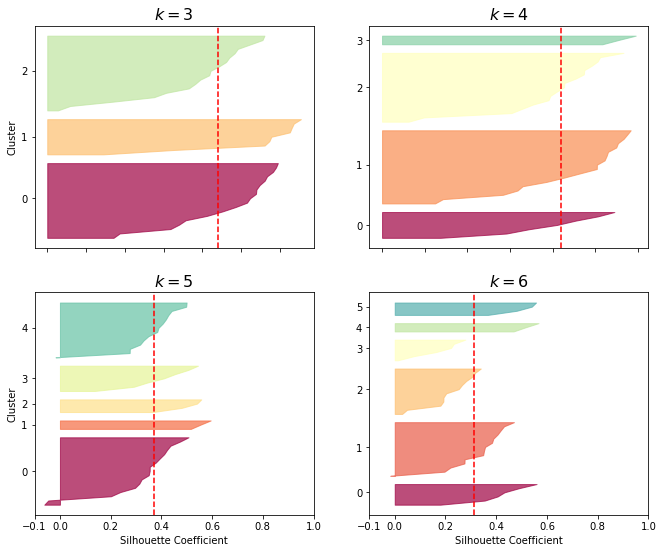

In [177]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(glasgow_grouped_clustering, y_pred)

    padding = len(glasgow_grouped_clustering) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)


plt.show()

## D.4 Fitting the data with K clusters

In [182]:
# set number of clusters
kclusters = 4
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=42).fit(glasgow_grouped_clustering)
# check cluster labels generated for each row in the dataframe

print(kmeans.labels_)


[3 3 0 0 2 0 3 2 1 2 2 1 0 0 2 1 1 1 2 2 2 2 2 2 2 1 1 1 2 0 0 2 1 2 1 1 1
 2 1 1 1 1 2 1 1]


In [209]:
# add clustering labels
neighborhoods_venues_sorted.drop(['Cluster Labels'], axis=1, inplace=True)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
    
glasgow_merged = final

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
glasgow_merged = glasgow_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Coverage')

# Remove NaN row
glasgow_merged.dropna(axis=0, how='any', inplace=True)

#Convert float values to int for use in folium
glasgow_merged['Cluster Labels'] = glasgow_merged['Cluster Labels'].astype(np.int64)
# glasgow_merged.sort_values(["Cluster Labels"], inplace=True)
glasgow_merged.head()

Postcode District                                           Coverage  \
0                 G1                                      Merchant City   
1                 G2                  Blythswood Hill, Anderston (part)   
2                 G3  Anderston, Finnieston, Garnethill, Park, Woodl...   
3                 G4  Calton (part), Cowcaddens (part), Drygate, Kel...   
4                 G5                                            Gorbals   
5                G11                    Broomhill, Partick, Partickhill   
6                G12  West End (part), Cleveden, Dowanhill, Hillhead...   
7                G13                     Anniesland, Knightswood, Yoker   
8                G14                               Whiteinch, Scotstoun   
9                G15                                         Drumchapel   
10               G20                Maryhill, North Kelvinside, Ruchill   
11               G21  Balornock, Barmulloch, Cowlairs, Royston, Spri...   
12               G22                      Milton, Parkhouse, Possilpark   
13               G23                               Lambhill, Summerston   
14               G31               Dennistoun, Haghill, Parkhead (part)   
15               G32  Carmyle, Tollcross, Mount Vernon, Lightburn, S...   
16               G33  Cardowan, Carntyne, Craigend, Cranhill, Gartha...   
17               G34                  Easterhouse, Easthall, Provanhall   
18               G40                      Bridgeton, Calton, Dalmarnock   
19               G41                           Pollokshields, Shawlands   
20               G42  Battlefield, Govanhill, Mount Florida, Strathb...   
21               G43                   Mansewood, Newlands, Pollokshaws   
22               G44  Cathcart, Simshill, Croftfoot, King's Park, Mu...   
23               G45                                         Castlemilk   
24               G46  Arden, Carnwadric, Deaconsbank, Giffnock, Kenn...   
25               G51       Govan, Ibrox, Drumoyne, Cessnock, Plantation   
26               G52           Cardonald, Hillington, Penilee, Mosspark   
27               G53  Darnley, Pollok, Crookston, Parkhouse, Priesth...   
28               G60                            Bowling, Old Kilpatrick   
29               G61                                           Bearsden   
30               G62                     Baldernock, Milngavie, Mugdock   
31               G64                             Bishopbriggs, Torrance   
32               G65                             Croy, Kilsyth, Twechar   
33               G66  Clachan of Campsie, Haughhead, Kirkintilloch, ...   
34               G67                                Cumbernauld (south)   
35               G68                      Cumbernauld (north), Dullatur   
36               G69  Baillieston, Bargeddie, Chryston, Garrowhill, ...   
37               G71  Birkenshaw, Bothwell, Broomhouse, Tannochside,...   
38               G72                               Blantyre, Cambuslang   
39               G73                                         Rutherglen   
40               G74                East Kilbride (north), Thorntonhall   
41               G75                   Auldhouse, East Kilbride (south)   
42               G76  Busby, Carmunnock, Clarkston, Eaglesham, Water...   
43               G77                                      Newton Mearns   
44               G78                      Barrhead, Neilston, Uplawmoor   

          Lat      Long  Price (£)  Cluster Labels  \
0   55.859773 -4.252307       1011               1   
1   55.863471 -4.258902        951               0   
2   55.867193 -4.273059        880               3   
3   55.871637 -4.253744        824               2   
4   55.843056 -4.242441        720               2   
5   55.871535 -4.302969        874               1   
6   55.883231 -4.294669        961               1   
7   55.883533 -4.327100        665               3   
8   55.880055 -4.352957        590               1   
9   55.91123

# E. Analysis and Conclusions and

## E.1 Show average price and count for each of the clusters 

In [190]:

df_test = glasgow_merged[['Postcode District', 'Price (£)', 'Cluster Labels']]
price_group = df_test.groupby(['Cluster Labels'], as_index=False).mean()
price_group['Count'] = df_test.groupby(['Cluster Labels']).size()

price_group.set_index('Cluster Labels')
price_group.sort_values('Price (£)', ascending=False)

Cluster Labels   Price (£)  Count
1               1  699.888889     18
3               3  697.333333      3
0               0  692.428571      7
2               2  644.470588     17

## E.2 Plot graph showing Number of unique venues and average rent price

In [191]:

#Select the venue category coloumns from glasgow_venues
venue_counts = glasgow_venues.groupby('Neighborhood').count()
venue = venue_counts[['Venue Category']]

# Get other data into new dataframe
temp = final[['Postcode District','Coverage', 'Price (£)']].copy()
temp.sort_values(['Coverage'], ascending = True, inplace=True)

#Reset index to help join
venue = venue.reset_index(drop=True)
temp = temp.reset_index(drop=True)

#Join the dataframes into one
count_vs_price = venue.join(temp)
#Sort values based on postcode
count_vs_price.sort_values(['Postcode District'], inplace=True)


Text(0, 0.5, 'Price (£)')

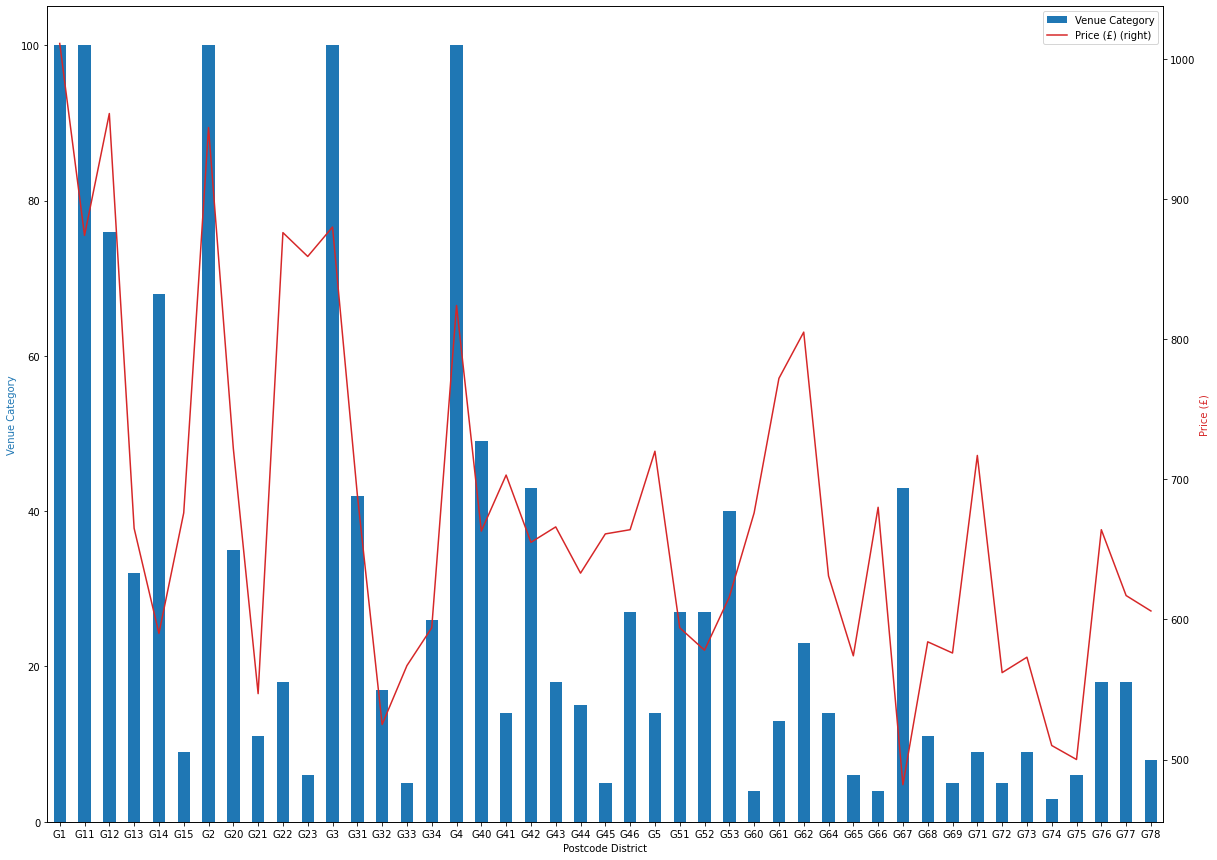

In [171]:

#Create the plot with two y axis, one for venue category and one for price
ax = count_vs_price.plot(xlabel = 'Postcode District', y = 'Venue Category', color = 'tab:blue', kind = 'bar', figsize=(20,15))
ax2 = count_vs_price.plot(x = 'Postcode District', y = 'Price (£)', kind = 'line', ax=ax, color = 'tab:red', secondary_y=True)
ax.set_ylabel('Venue Category', color='tab:blue')
ax2.set_ylabel('Price (£)', color ='tab:red')

From this plot we can clearly see a correlation between postcodes with high number of venue categorie (i.e local amenities) and average rent price.

Our goal was to find locations with both the highest number of amenities for the lowest rent price.

From the plot, my top choices include: G14 - Whiteinch, Scotstoun,
                                       G40 - Bridgeton, Calton, Dalmarnock
                                       G42 - Battlefield, Govanhill, Mount Florida, 
                                       G67 - Cumbernauld (south)
                                       G53 - Darnley, Pollok, Crookston,

There venue totals and prices are displayed in the table 'Potential Locations' below.

In [162]:
selected_post_codes = ['G14','G40','G42','G67','G53']
potential_loc = count_vs_price.loc[count_vs_price['Postcode District'].isin(selected_post_codes)]
potential_loc

Venue Category Postcode District  \
44              68               G14   
15              49               G40   
8               43               G42   
28              40               G53   
27              43               G67   

                                             Coverage  Price (£)  
44                               Whiteinch, Scotstoun        590  
15                      Bridgeton, Calton, Dalmarnock        663  
8   Battlefield, Govanhill, Mount Florida, Strathb...        655  
28  Darnley, Pollok, Crookston, Parkhouse, Priesth...        616  
27                                Cumbernauld (south)        482

## E.5 Plot map with clusters

In [207]:
from matplotlib import cm
from matplotlib import colors
 
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(glasgow_merged['Lat'], glasgow_merged['Long'], glasgow_merged['Coverage'], glasgow_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(world_map)


# display map_
world_map

## Cluster 0 - Good ammenities / Mid to high rent price

In [192]:
glasgow_merged.loc[glasgow_merged['Cluster Labels'] == 0, glasgow_merged.columns[[1] + list(range(4, glasgow_merged.shape[1]))]]

Coverage  Price (£)  \
14               Dennistoun, Haghill, Parkhead (part)        689   
24  Arden, Carnwadric, Deaconsbank, Giffnock, Kenn...        664   
38                               Blantyre, Cambuslang        562   
9                                          Drumchapel        676   
30                     Baldernock, Milngavie, Mugdock        805   
1                   Blythswood Hill, Anderston (part)        951   
41                   Auldhouse, East Kilbride (south)        500   

    Cluster Labels       1st Most Common Venue 2nd Most Common Venue  \
14               0                 Pizza Place                Bakery   
24               0                 Supermarket           Pizza Place   
38               0                Home Service           Men's Store   
9                0  Construction & Landscaping        Discount Store   
30               0                         Bar                 Hotel   
1                0                         Bar                 Hotel   
41               0            Department Store    Athletics & Sports   

      3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
14                  Brewery         Train Station         Grocery Store  
24            Train Station         Deli / Bodega                  Park  
38         Business Service         Train Station                Market  
9                  Pharmacy         Train Station           Supermarket  
30              Supermarket                 Plaza                  Café  
1              Cocktail Bar           Coffee Shop    Italian Restaurant  
41  Health & Beauty Service           Supermarket                  Café

## Cluster 1 - Plenty amenities/ Higher average rent price

In [199]:
glasgow_merged.loc[glasgow_merged['Cluster Labels'] == 1, glasgow_merged.columns[[1] + list(range(4, glasgow_merged.shape[1]))]]

Coverage  Price (£)  \
5                     Broomhill, Partick, Partickhill        874   
32                             Croy, Kilsyth, Twechar        574   
25       Govan, Ibrox, Drumoyne, Cessnock, Plantation        594   
34                                Cumbernauld (south)        482   
43                                      Newton Mearns        617   
21                   Mansewood, Newlands, Pollokshaws        666   
20  Battlefield, Govanhill, Mount Florida, Strathb...        655   
19                           Pollokshields, Shawlands        703   
18                      Bridgeton, Calton, Dalmarnock        663   
17                  Easterhouse, Easthall, Provanhall        594   
31                             Bishopbriggs, Torrance        631   
13                               Lambhill, Summerston        859   
12                      Milton, Parkhouse, Possilpark        876   
42  Busby, Carmunnock, Clarkston, Eaglesham, Water...        664   
8                                Whiteinch, Scotstoun        590   
6   West End (part), Cleveden, Dowanhill, Hillhead...        961   
35                      Cumbernauld (north), Dullatur        584   
0                                       Merchant City       1011   

    Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
5                1                  Café                   Bar   
32               1                 Hotel        Discount Store   
25               1                  Café         Metro Station   
34               1        Clothing Store        Discount Store   
43               1            Steakhouse           Supermarket   
21               1         Train Station           IT Services   
20               1                  Café                   Pub   
19               1                  Park         Train Station   
18               1               Brewery              Pharmacy   
17               1              Pharmacy        Discount Store   
31               1        Discount Store  Gym / Fitness Center   
13               1         Train Station     Indian Restaurant   
12               1           Supermarket        Discount Store   
42               1         Grocery Store           Gas Station   
8                1        Clothing Store              Pharmacy   
6                1                   Bar           Coffee Shop   
35               1         Grocery Store            Sports Bar   
0                1           Coffee Shop    Italian Restaurant   

      3rd Most Common Venue 4th Most Common Venue       5th Most Common Venue  
5        Italian Restaurant                   Pub           Indian Restaurant  
32              Supermarket           Gas Station               Grocery Store  
25                Gift Shop      Business Service                 Bus Station  
34     Fast Food Restaurant           Supermarket                 Pizza Place  
43        Indian Restaurant       Photography Lab                         Gym  
21             Tennis Court     Indian Restaurant              Hardware Store  
20       Italian Restaurant         Grocery Store  Construction & Landscaping  
19            Metro Station           Supermarket               Grocery Store  
18              Supermarket         Train Station                      Bakery  
17           Clothing Store         Shopping Mall                    Boutique  
31           Shopping Plaza           Supermarket                 Coffee Shop  
13  Health & Beauty Service           Supermarket               Women's Store  
12          Harbor / Marina           Gas Station                       Canal  
42     Gym / Fitness Center  Fast Food Restaurant            Business Service  
8      Fast Food Restaurant           Coffee Shop               Jewelry Store  
6                Restaurant         Grocery Store          Italian Restaurant  
35            Train Station              Bus Stop                        Café  
0                       Bar                  Café        

## Cluster 2 - Outskirts - Good ammenities/ Low Price

In [194]:
glasgow_merged.loc[glasgow_merged['Cluster Labels'] == 2, glasgow_merged.columns[[1] + list(range(4, glasgow_merged.shape[1]))]]

Coverage  Price (£)  \
40                East Kilbride (north), Thorntonhall        510   
36  Baillieston, Bargeddie, Chryston, Garrowhill, ...        576   
37  Birkenshaw, Bothwell, Broomhouse, Tannochside,...        717   
39                                         Rutherglen        573   
33  Clachan of Campsie, Haughhead, Kirkintilloch, ...        680   
22  Cathcart, Simshill, Croftfoot, King's Park, Mu...        633   
28                            Bowling, Old Kilpatrick        676   
27  Darnley, Pollok, Crookston, Parkhouse, Priesth...        616   
26           Cardonald, Hillington, Penilee, Mosspark        578   
23                                         Castlemilk        661   
16  Cardowan, Carntyne, Craigend, Cranhill, Gartha...        567   
15  Carmyle, Tollcross, Mount Vernon, Lightburn, S...        525   
10                Maryhill, North Kelvinside, Ruchill        722   
4                                             Gorbals        720   
3   Calton (part), Cowcaddens (part), Drygate, Kel...        824   
29                                           Bearsden        772   
44                      Barrhead, Neilston, Uplawmoor        606   

    Cluster Labels       1st Most Common Venue       2nd Most Common Venue  \
40               2                       Plaza               Grocery Store   
36               2  Construction & Landscaping          Chinese Restaurant   
37               2                 IT Services               Train Station   
39               2                       Hotel                    Bus Stop   
33               2                Soccer Field          Athletics & Sports   
22               2                       Hotel              Hardware Store   
28               2                 Pizza Place                         Pub   
27               2              Clothing Store                 Coffee Shop   
26               2                 Supermarket               Grocery Store   
23               2                Home Service  Construction & Landscaping   
16               2           Convenience Store                        Park   
15               2                 Supermarket               Grocery Store   
10               2               Grocery Store                        Café   
4                2                Dance Studio                         Gym   
3                2                       Hotel                         Bar   
29               2                    Platform               Grocery Store   
44               2               Grocery Store        Fast Food Restaurant   

         3rd Most Common Venue   4th Most Common Venue  \
40          Italian Restaurant       Fish & Chips Shop   
36               Train Station               Gift Shop   
37              Cricket Ground          Sandwich Place   
39                 Supermarket           Train Station   
33                       Trail                  Castle   
22                 Rugby Pitch  Furniture / Home Store   
28               Train Station         Harbor / Marina   
27              Cosmetics Shop            Burger Joint   
26                      Bakery                Pharmacy   
23                    Bus Stop                Gym Pool   
16                         Gym          Sandwich Place   
15  Construction & Landscaping  Thrift / Vintage Store   
10                 Pizza Place                     Pub   
4                  Flea Market                 Stadium   
3           Italian Restaurant             Coffee Shop   
29        Fast Food Restaurant       Food & Drink Shop   
44           Electronics Store             Supermarket   

         5th Most Common Venue  
40  Financial or Legal Service  
36               Women's Store  
37                 Supermarket  
39                        Park  
33               Women's Store  
22          Chinese Restaurant  
28                    Dive Bar  
27          Italian Restaurant  
26               Deli / Bodega  
23               Shopping Mall  
16     

## Cluster 3 - OK ammenities/ High price

In [196]:
glasgow_merged.loc[glasgow_merged['Cluster Labels'] == 3, glasgow_merged.columns[[1] + list(range(4, glasgow_merged.shape[1]))]]

Coverage  Price (£)  \
11  Balornock, Barmulloch, Cowlairs, Royston, Spri...        547   
7                      Anniesland, Knightswood, Yoker        665   
2   Anderston, Finnieston, Garnethill, Park, Woodl...        880   

    Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
11               3         Train Station  Fast Food Restaurant   
7                3                  Café              Platform   
2                3                   Bar            Restaurant   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
11        Discount Store          Soccer Field             Pawn Shop  
7         Discount Store         Train Station                   Pub  
2      Indian Restaurant                  Café           Coffee Shop

# Top Picks Table + ammenities

In [205]:
sel_post_codes = ['G14','G40','G42','G67','G53']

top_picks = glasgow_merged.loc[glasgow_merged['Postcode District'].isin(sel_post_codes)]

top_picks.sort_values('Postcode District')

Postcode District                                           Coverage  \
8                G14                               Whiteinch, Scotstoun   
18               G40                      Bridgeton, Calton, Dalmarnock   
20               G42  Battlefield, Govanhill, Mount Florida, Strathb...   
27               G53  Darnley, Pollok, Crookston, Parkhouse, Priesth...   
34               G67                                Cumbernauld (south)   

          Lat      Long  Price (£)  Cluster Labels 1st Most Common Venue  \
8   55.880055 -4.352957        590               1        Clothing Store   
18  55.854865 -4.227452        663               1               Brewery   
20  55.826175 -4.267864        655               1                  Café   
27  55.831183 -4.339166        616               2        Clothing Store   
34  55.944794 -3.988847        482               1        Clothing Store   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
8               Pharmacy  Fast Food Restaurant           Coffee Shop   
18              Pharmacy           Supermarket         Train Station   
20                   Pub    Italian Restaurant         Grocery Store   
27           Coffee Shop        Cosmetics Shop          Burger Joint   
34        Discount Store  Fast Food Restaurant           Supermarket   

         5th Most Common Venue  
8                Jewelry Store  
18                      Bakery  
20  Construction & Landscaping  
27          Italian Restaurant  
34                 Pizza Place